# 第12章 生成式深度学习

## 12.1 用变分自编码器生成图像
	变分自编码器是自编码器的改进版本，自编码器是一种无监督学习，但它无法产生新的内容，变分自编码器对其潜在空间进行拓展，使其满足正态分布，情况就大不一样了。
### 12.1.1 自编码器
	自编码器是通过对输入X进行编码后得到一个低维的向量z，然后根据这个向量还原出输入X。通过对比X与X ̃的误差，再利用神经网络去训练使得误差逐渐减小，从而达到非监督学习的目的。图12-1 为自编码器的架构图。
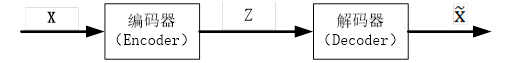
<center>图12-1 自编码器架构图</center>

自编码器因不能随意产生合理的潜在变量，从而导致它无法产生新的内容。因为潜在变量Z都是编码器从原始图片中产生的。为解决这一问题，人们对潜在空间Z（潜在变量对应的空间）增加一些约束，使Z满足正态分布，由此就出现了VAE模型，VAE对编码器添加约束，就是强迫它产生服从单位正态分布的潜在变量。正是这种约束，把VAE和自编码器区分开来。

### 12.1.2 变分自编码器
	变分自编码器关键一点就是增加一个对潜在空间Z的正态分布约束，如何确定这个正态分布就成主要目标，我们知道要确定正态分布，只要确定其两个参数均值u和标准差σ。那么如何确定u、σ？用一般的方法或估计比较麻烦，效果也不好，用神经网络去拟合，简单高效。图12-2 为VAE的架构图。
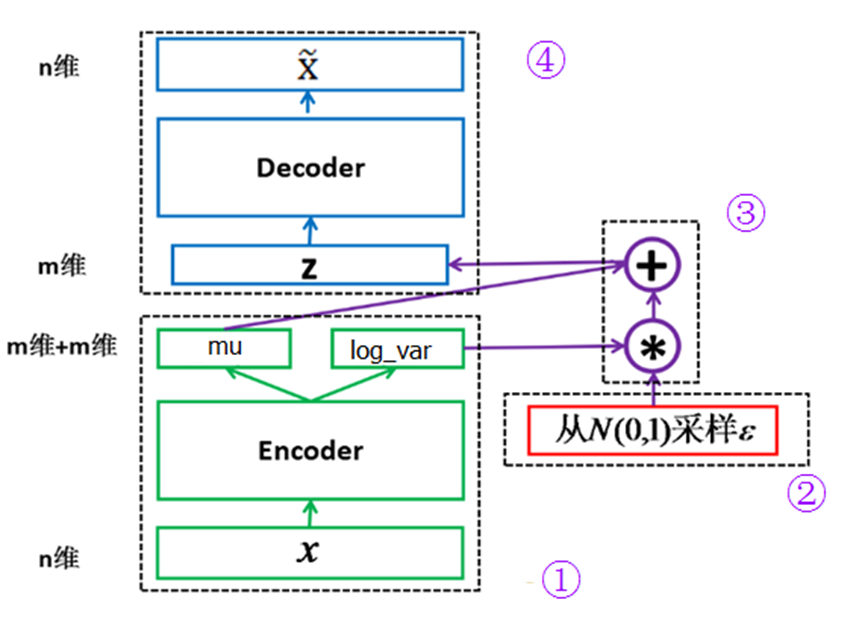
<center>图12-2 VAE架构图</center>
	在图12-2中，模块①的功能把输入样本X通过编码器输出两个m维向量（mu、log_var）,这两个向量是潜在空间（假设满足正态分布）的两个参数（相当于均值和方差）。那么如何从这个潜在空间采用一个向量Z?
	这里假设潜在正态分布能生成输入图像，从标准正态分布N(0,I)中采样一个ε（模块②的功能），然后使
                  Z=mu+exp⁡(log_var)*ε                                （12.1）

这也是模块③的主要功能。  
	Z是从潜在空间抽取的一个向量，Z通过解码器生成一个样本X ̃，这是模块④的功能。
	这里ε是随机采样的，这就可保证潜在空间的连续性、良好的结构性。而这些特性使得潜在空间的每个方向都表示数据中有意义的变化方向。
	以上这些步骤构成整个网络的正向传播过程，反向传播如何进行？要确定反向传播就涉及到损失函数了，损失函数是衡量模型优劣的主要指标。这里我们需要从以下两个方面进行衡量。  
1）生成的新图像与原图像的相似度；  
2）隐含空间的分布与正态分布的相似度。  
	度量图像的相似度一般采用交叉熵，度量两个分布的相似度一般采用KL散度(Kullback-Leibler divergence)。这两个度量的和构成了整个模型的损失函数。

### 12.1.3 用变分自编码器生成图像实例
	前面我们介绍了VAE的架构和原理，至此对VAE的“蓝图”就有了大致了解，如何实现这个蓝图？这节我们将结合代码，用TensorFlow实现VAE。此外，还包括在实现过程中需要注意的一些问题，为便于说明起见，数据集采用MNIST。
使用卷积神经网络来构建编辑器和解码器，并使用x和z分别表示观测值和潜在变量。
- 编码器。这里定义了近似后验分布q(z|x) ，该后验分布以观测值作为输入，并输出用于潜在表示的条件分布的一组参数。在本示例中，我们仅将此分布建模为对角高斯模型。在这种情况下，编码器将输出因式分解的高斯均值和对数方差参数。
- 解码器。解码器将隐变量作为输入，并输出用于观测条件分布的参数p(x|z).我们对隐变量使用单位高斯先验分布。
- 采样。我们从q(z|x)中采样，方法是先从单位高斯中采样，然后乘以标注差并加上平均值。这样可以确保梯度能确保梯度能传回编码器。
- 网络结构。对于编码器，我们使用了两个卷积层加一个全连接层，而对于解码器，我们使用全连接层加3个反卷积层。 注意：训练VAE过程中要避免使用批归一化，因为这样会导致额外的随机性，从而加剧随机抽样的不稳定性。	


## 1.导入相关的库

In [1]:
import os
import time
import struct
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import tensorflow as tf
from IPython import display
print(tf.__version__)


2.4.0


## 2.导入数据

### 把标签转换为热编码

In [2]:
def dense_to_one_hot(labels_dense, num_classes=10):
  """将类标签从标量转换为一个独热向量"""
  num_labels = labels_dense.shape[0]
  index_offset = np.arange(num_labels) * num_classes
  labels_one_hot = np.zeros((num_labels, num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
  return labels_one_hot


### 定义加载函数

In [3]:
def load_mnist(path, kind='train'):
    """根据指定路径加载数据集"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
        labels=dense_to_one_hot(labels)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)


    return images, labels


### 导入数据

In [4]:
X_train, y_train = load_mnist('../data/MNIST/raw/', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))
print('Rows: %d, columns: %d' % ( y_train.shape[0],  y_train.shape[1]))

X_test, y_test = load_mnist('../data/MNIST/raw/', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))


Rows: 60000, columns: 784
Rows: 60000, columns: 10
Rows: 10000, columns: 784


In [5]:
# 构建数据集

train_images = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
test_images = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

# 化到0-1之间
train_images /= 255.0
test_images /= 255.0

# 二值化
train_images[train_images>=0.5] = 1.0
train_images[train_images<0.5] = 0.0
test_images[test_images>=0.5] = 1.0
test_images[test_images<0.5] = 0.0

#　超参数
ＴRAIN_BUF=60000
BATCH_SIZE = 100
TEST_BUF = 10000

### 分批和打乱数据

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)


## 3.构建生成网络和推理网络
我们使用卷积网络来构建生成网络和推理网络。并使用x和z分别表示观测值和潜在变量
#### 生成网络
生成网络将隐变量作为输入，并输出用于观测条件分布的参数p(x|z).我们对隐变量使用单位高斯先验分布。
#### 推理网络
这里定义了近似后验分布q(z|x) ，该后验分布以观测值作为输入，并输出用于潜在表示的条件分布的一组参数。在本示例中，我们仅将此分布建模为对角高斯模型。在这种情况下，推断网络将输出因式分解的高斯均值和对数方差参数
#### 采样
我们从q(z|x)中采样，方法是先从单位高斯中采样，然后乘以标注差并加上平均值。这样可以确保梯度能确保梯度能传回推理网络。
#### 网络结构
对于推理网络，我们使用了两个卷积层加一个全连接层，而对于生成网络，我们使用全连接层加3个反卷积层。 注意：训练VAE过程中要避免使用批归一化，因为这样会导致额外的随机性，从而加剧随机抽样的不稳定性

In [7]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim+latent_dim)
        ])
        self.generative_net = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation='relu'),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=(2, 2),
                padding='SAME', activation='relu'
            ),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=(2, 2),
                padding='SAME', activation='relu'
            ),
            # 不使用激活函数
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=(1, 1),
                padding='SAME'
            ),
            
        ])
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2,
                               axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

## 4.定义损失函数和优化器

In [8]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2.0 * np.pi)
    return tf.reduce_sum(
    -0.5*((sample -mean)**2.0 * tf.exp(-logvar)+logvar+log2pi),
        axis=raxis
    )

@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2,3])
    logpz = log_normal_pdf(z, 0.0, 0.0)
    logpz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z+logpz-logpz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## 5.训练模型

In [9]:
epochs = 100
latent_dim = 50
num_examples_to_generate = 16

# 保持随机向量恒定以进行生成（预测），以便看到改进。
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = VAE(latent_dim)

In [10]:
# 使用输入生成图片
def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout 最小化两个子图之间的重叠
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

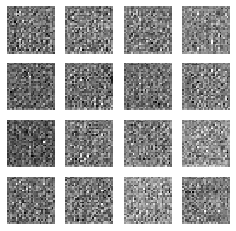

In [11]:
generate_and_save_images(model, 0, random_vector_for_generation)

Epoch: 100, Test set ELBO: -78.17051696777344, time elapse for current epoch 3.72489070892334


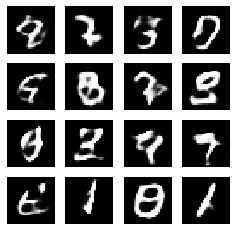

In [12]:
for epoch in range(1, epochs+1):
    start_time = time.time()
    for train_x in train_dataset:
        compute_apply_gradients(model, train_x, optimizer)
    end_time = time.time()
    if epoch % 20 == 0:
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            loss(compute_loss(model, test_x))
        elbo = -loss.result()
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
        generate_and_save_images(model, epoch, random_vector_for_generation)

图12-3  AVE构建图片  
	图12-3中，奇数列为原图像，偶数列为原图像重构的图像。从这个结果可以看出重构图像效果还不错。
